# Import supporting package

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from DataContainer.ReadData import read_hdf5_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:49232' processes=6 threads=60, memory=55.88 GiB>

# Read data

## Set file path

In [3]:
# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/*.h5"
# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/2023-04-18_0003_Evaporative_Cooling_000.h5"

# filepath = "//DyLabNAS/Data/Repetition_scan/2023/04/21/0002/*.h5"

# filepath = r"./testData/0003/*.h5"

filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/*.h5"

In [4]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    # "images/ODT_1_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_1",
    # "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_2",
}

datasetDict = {
    dskey[groupList[i]]: read_hdf5_file(filepath, groupList[i])
    for i in range(len(groupList))
}

## Rechunk the data for parallel computing

In [5]:
dataset = datasetDict["camera_1"]

scanAxis = dataset.scanAxis

dataset = dataset.chunk(
    {
        "compZ_current_sg": "auto",
        "runs": 2,
        "x": "auto",
        "y": "auto",
    }
)

# Calculate absorption imaging

## get OD images

In [6]:
dataset = imageAnalyser.get_absorption_images(dataset)

dataset

<xarray.Dataset>
Dimensions:           (compZ_current_sg: 300, runs: 2, x: 1200, y: 1920)
Coordinates:
  * compZ_current_sg  (compZ_current_sg) float64 0.175 0.176 ... 0.473 0.474
  * runs              (runs) float64 0.0 1.0
Dimensions without coordinates: x, y
Data variables:
    atoms             (compZ_current_sg, runs, x, y) uint16 dask.array<chunksize=(14, 2, 1200, 1920), meta=np.ndarray>
    background        (compZ_current_sg, runs, x, y) uint16 dask.array<chunksize=(14, 2, 1200, 1920), meta=np.ndarray>
    dark              (compZ_current_sg, runs, x, y) uint16 dask.array<chunksize=(14, 2, 1200, 1920), meta=np.ndarray>
    shotNum           (compZ_current_sg, runs) <U3 dask.array<chunksize=(300, 2), meta=np.ndarray>
    OD                (compZ_current_sg, runs, x, y) float64 dask.array<chunksize=(14, 2, 1200, 1920), meta=np.ndarray>
Attributes: (12/100)
    TOF_free:                          0.02
    abs_img_freq:                      110.866
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    z_offset:                          compZ_current_sg
    z_offset_img:                      compZ_current_sg
    compZ_current_sg:                  [0.175 0.176 0.177 0.178 0.179 0.18  0...
    runs:                              [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0...
    scanAxis:                          ['compZ_current_sg', 'runs']
    scanAxisLength:                    [600. 600.]

## Select region of interests

In [7]:
imageAnalyser.center = (880, 960)
imageAnalyser.span = (100,100)
imageAnalyser.fraction = (0.1, 0.1)

# imageAnalyser.center = (890, 1150)
# imageAnalyser.span = (600,600)
# imageAnalyser.fraction = (0.1, 0.1)

# imageAnalyser.center = (890, 950)
# imageAnalyser.span = (100,100)
# imageAnalyser.fraction = (0.1, 0.1)

dataset_crop = imageAnalyser.crop_image(dataset)

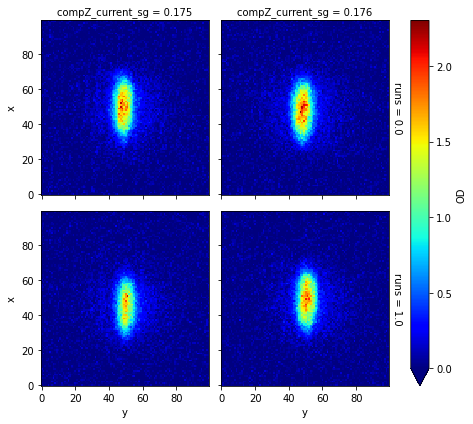

In [8]:
dataset_crop.OD.isel(**{scanAxis[0]:np.arange(2), 'runs':range(dataset_crop.OD['runs'].size)}).plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])

## Remove the background

In [9]:
dataset_crop['OD'] = dataset_crop['OD'] + 500

In [10]:
dataset_crop['OD'] = imageAnalyser.substract_offset(dataset_crop['OD'])

# Test Fit

In [11]:
fitAnalyser = FitAnalyser("Gaussian-2D", fitDim=2)

params = fitAnalyser.guess(dataset_crop.OD, dask="parallelized")

In [12]:
fitResult = fitAnalyser.fit(dataset_crop.OD, params, dask="parallelized")

In [13]:
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(100), y=np.arange(100))

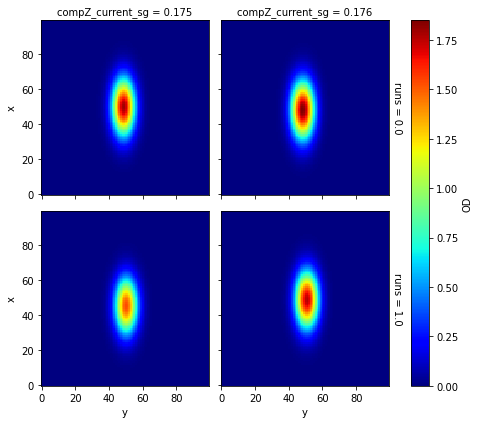

In [14]:
fitCurve.isel(**{scanAxis[0]:np.arange(2), 'runs':range(dataset_crop.OD['runs'].size)}).plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])

# Get the Ncount

In [15]:
Ncount = dataset_crop.OD.sum(dim=(scanAxis[1], 'x', 'y'))

AttributeError: 'Line2D' object has no property 'fig'

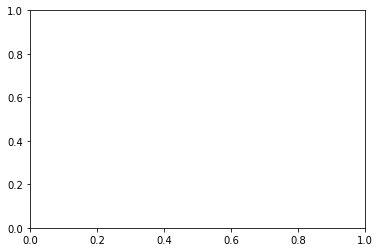

In [24]:
# fig = plt.figure()
# Ncount.plot(fig=fig)

In [23]:
fig

AttributeError: 'Line2D' object has no attribute 'ylim'